# Especialização em Ciência de Dados - PUC-Rio
# Machine Learning
## Exercício 4: Comparação de modelos de clusterização



---


__Alunos:__ <br>
        Cícero Felipe Ricci Bressane <br>
        José Douglas Nascimento <br>
        Ronaldo Costa <br>
        Victor Mouffron Carvalho Machado

---

# Comente, em português, cada uma das linhas (ou bloco de linhas) do exemplo abaixo de comparação de algoritmos de clustering. Em seguida, responda: O que você aprendeu neste exercício?#

__Nesse exercício foram criados diferentes datasets e aplicados diversos algoritmos de clusterização presentes na biblioteca sklearn. Cada linha da figura representa um dataset criado e cada coluna representa um algoritmo. Percebe-se que alguns algoritmos são superiores do que outros em determinados datasets. Apesar de percebermos algumas características desses algoritmos não podemos generalizar um desempenho superior para todos os datasets. Além disso, como indica a documentação do sklearn, apesar da intuição fornecida pela imagem, essa pode não prevalecer em dimensões maiores__

# Comparing different clustering algorithms on toy datasets


https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

Automatically created module for IPython interactive environment


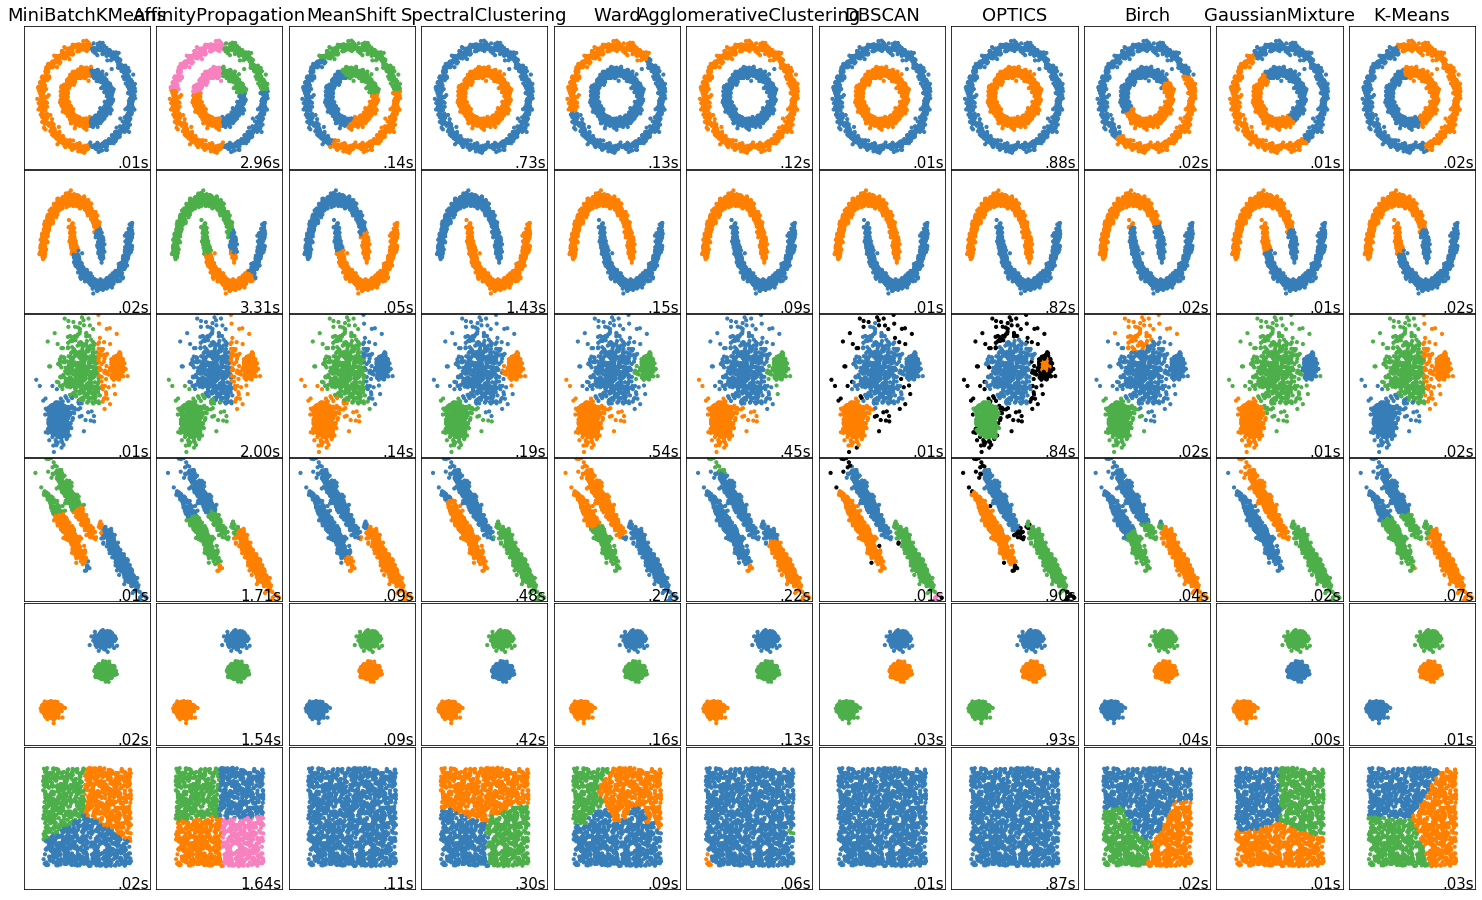

In [2]:
%matplotlib inline
print(__doc__)

# importando as bibliotecas necessárias
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0) # fixando a semente para manter a reprodutibilidade do experimento

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500 # número de amostras

# criando datasets usando o sklearn para a clusterização 
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, #criando círculos
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05) #criando "luas"
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)  #criando "bolhas"
no_structure = np.random.rand(n_samples, 2), None  #criando dataset sem estrutura definida (aleatório)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5)) # definindo tamnho do gráfico
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

# criando lista com tuplas de datasets e parâmetros
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets): # iterando no lista datasets
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset # desempacotando a tupla

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X) # normalizando o dataset

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    
    # instanciando diferentes tipos de algoritmos de clusterização da biblioteca sklearn
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    kmeans = cluster.KMeans(
        n_clusters=params['n_clusters'], init='random')

# criando tupla de tuplas com nome do algoritmo e instância criada
    clustering_algorithms = (  
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('K-Means', kmeans)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X) #iterando por cada algoritmo e treinando o cluster

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num) # criando cada subplot
        if i_dataset == 0:
            plt.title(name, size=18)

        # definindo cores e outros elementos gráficos, como tamanho dos eixos
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show() #plota os gráficos criados